<a href="https://colab.research.google.com/github/rae-fahrenholtz/Elon/blob/main/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem of Interest

Predict Tesla (TSLA) stock price given Technoking of Tesla, aka CEO, Elon Musk social media influence: \\

- Twitter Influence
  - Interest in what Elon has to *SAY*  
- Wiki Searches
  - Interest in *WHO* Elon is as a person
- Google relative popularity
  - Interest in *WHO* Elon is as a person
- S&P500 Index
  - Stock Index to capture general trend of the economy 


#Data Sources

## Twitter

Gathered from two sources:

1. [Kaggle](https://www.kaggle.com/ayhmrba/elon-musk-tweets-2010-2021/version/2)
  - Used from Jan 2017 to Mid March 2021 

2. [Twitter API](https://developer.twitter.com/en/docs/twitter-api/tweets/timelines/api-reference/get-users-id-tweets)   
  - Used from Mid March 2021 to Dec 2021
  - Created bash script [elon.sh](https://github.com/rae-fahrenholtz/Elon/blob/main/elon.sh) to run multiple calls to API
  - Requires [Academic Access Level](https://developer.twitter.com/en/docs/twitter-api/getting-started/about-twitter-api#v2-access-level) to obtain the full amount of tweets
    - not enough credibility through Thinkful for me to obtain at this time

## Wikipedia
- [Wiki API](https://www.mediawiki.org/wiki/API:Main_page)

## Google
- Pytrends, Unofficial Google Trends API
- [Pytrends Guide](https://lazarinastoy.com/the-ultimate-guide-to-pytrends-google-trends-api-with-python/)

## S&P500 Index
- FRED Python API
- [FRED Python API Guide](https://analyzingalpha.com/get-economic-data-fred-python-api)

# Load Data

In [2]:
#api
!pip install pytrends
!pip install finnhub-python

In [3]:
#general
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#json
from pandas import json_normalize
import base64
import requests
import json
import urllib

#api
import pandas_datareader.data as web
from pytrends.request import TrendReq
import finnhub

#datetime
import matplotlib.dates as md
import datetime
from datetime import timedelta

## Twitter Data

Framework:

`tweet_df`: pandas dataframe with all available features from kaggle

`api_tweet_df`: pandas dataframe with all available features from api request

`my_tweet_df`: pandas dataframe with average number of daily likes from Kaggle data source

`my_api_tweet_df`: pandas dataframe with average number of daily likes from Twitter API data source

`nlike_tweet_df`: pandas data frame of average daily tweet likes from both data sources

### Kaggle Twitter Data

Data from Kaggle available from two sources:

- Original [Kaggle](https://www.kaggle.com/ayhmrba/elon-musk-tweets-2010-2021/version/2) Data

- csv files saved on Github [repo](https://github.com/rae-fahrenholtz/Elon/tree/main/data) by year in the format `elon_tweets_20xx.csv`


#### `tweet_df`: pandas dataframe with all available features from kaggle

In [4]:
#function to index and clean Elon musk tweet data from github repo

#year: str, no spaces
#possible years: [2017 - 2021]

def get_yearly_elon_tweets(year):
  
  #define url 
  url_a = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/elon_tweets_'
  url_b = year
  url_c = '.csv'
  url = url_a + url_b + url_c

  #read data
  df = pd.read_csv(url, parse_dates=['date'])
  
  #index with date (no hourly)
  df.index = pd.DatetimeIndex(df['date']).floor('D')
  
  #data cleaning
  #only tweets in coresponding year
  start_date = year + '0101' 
  end_date = year + '1231' 
  query_str = start_date + ' <= date <= ' + end_date
  df = df.query(query_str)
  
  #sort index from earliest to newest
  df = df.sort_index()
  
  return(df)

In [5]:
df_2017 = get_yearly_elon_tweets('2017')
df_2018 = get_yearly_elon_tweets('2018')
df_2019 = get_yearly_elon_tweets('2019')
df_2020 = get_yearly_elon_tweets('2020')
df_2021 = get_yearly_elon_tweets('2021')

In [6]:
tweet_df = pd.concat([df_2017, df_2018, df_2019, df_2020, df_2021], axis=0)

In [7]:
tweet_df.shape

(10218, 39)

In [8]:
tweet_df.columns

Index(['Unnamed: 0', 'id', 'conversation_id', 'created_at', 'date', 'timezone',
       'place', 'tweet', 'language', 'hashtags', 'cashtags', 'user_id',
       'user_id_str', 'username', 'name', 'day', 'hour', 'link', 'urls',
       'photos', 'video', 'thumbnail', 'retweet', 'nlikes', 'nreplies',
       'nretweets', 'quote_url', 'search', 'near', 'geo', 'source',
       'user_rt_id', 'user_rt', 'retweet_id', 'reply_to', 'retweet_date',
       'translate', 'trans_src', 'trans_dest'],
      dtype='object')

In [9]:
tweet_df.head(3)

,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,user_id,user_id_str,username,name,day,hour,link,urls,photos,video,thumbnail,retweet,nlikes,nreplies,nretweets,quote_url,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-05,1160,817123579343028227,817123579343028227,1.483652e+12,2017-01-05 21:40:17,0,NaN,Hold-down firing of @SpaceX Falcon 9 at Vanden...,en,[],[],44196397,44196397,elonmusk,Elon Musk,4,21,https://twitter.com/elonmusk/status/8171235793...,[],[],0,NaN,False,14041,469,2873,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2017-01-06,1159,817509115555643392,817433160778715139,1.483744e+12,2017-01-06 23:12:16,0,NaN,@pensasoda https://t.co/6Ies7xBuBs via @WIRED,und,[],[],44196397,44196397,elonmusk,Elon Musk,5,23,https://twitter.com/elonmusk/status/8175091155...,['https://www.wired.com/2016/12/trumps-chief-s...,[],0,NaN,False,247,27,80,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'pensasoda', 'name': 'Brutall...",NaN,NaN,NaN,NaN
2017-01-07,1158,817580438558359552,817123579343028227,1.483761e+12,2017-01-07 03:55:41,0,NaN,@fatihorhan @SpaceX That was a great game,en,[],[],44196397,44196397,elonmusk,Elon Musk,6,3,https://twitter.com/elonmusk/status/8175804385...,[],[],0,NaN,False,247,16,25,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'fatihorhan', 'name': 'Fatih ...",NaN,NaN,NaN,NaN


#### `my_tweet_df`: Average daily tweet likes

In [10]:
#excludes tweet replies (replies excluded in API data)
my_tweet_df = tweet_df[tweet_df['reply_to'] == '[]']

#extract column of interest, nlikes
my_tweet_df = pd.concat([my_tweet_df['nlikes']], names=['nlikes'], axis=1)

#average likes per day, days with no tweets --> NaN
my_tweet_df = my_tweet_df.resample('D').mean()
my_tweet_df = my_tweet_df.fillna(0)    #NaN --> 0 

#reindex to include days of no tweets in beginning of year
all_dates = pd.date_range(start='1/1/2017', end='3/20/2021')
my_tweet_df = my_tweet_df.reindex(all_dates, fill_value=0)

In [11]:
my_tweet_df.shape

(1540, 1)

In [12]:
my_tweet_df.tail(3)

,nlikes
2021-03-18,164435.333333
2021-03-19,327982.000000
2021-03-20,370258.000000


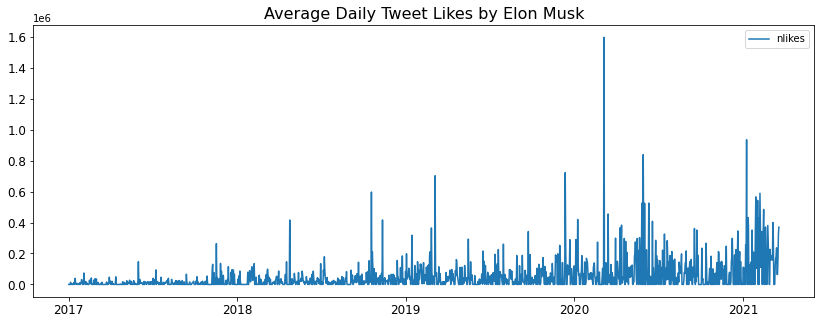

In [13]:
plt.figure(figsize=(14,5))

ax = sns.lineplot(data=my_tweet_df)  

ax.xaxis.set_major_locator(md.YearLocator(1,1,1))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%M-%D'))
ax.set_xticklabels(['2016', '2017', '2018', '2019', '2020', '2021'])

plt.xticks(size=12)
plt.yticks(size=12)

plt.title('Average Daily Tweet Likes by Elon Musk', size=16)

plt.show()

### Twitter API Data

- 600 most recent tweets from Elon Musk (excluding replies and retweets) from the [Twitter API](https://developer.twitter.com/en/docs/twitter-api/tweets/timelines/api-reference/get-users-id-tweets)

- json responses saved in [repo](https://www.github.com/rae-fahrenholtz/Elon/data) in 6 files named by most recent tweet date in file

- used to complete 2021 kaggle data 

#### `api_tweet_df`: pandas dataframe with all available features from Twitter API

In [14]:
# function to: json response --> pandas dataframe  
# json data is in repo: https://www.github.com/rae-fahrenholtz/Elon/data

def my_json_to_df(url):
    
  master = url
  req = requests.get(master)
  req = req.text                        #json as string
  d_json = json.loads(req)              #json as dictionary

  likes = []                            #initialize lists
  quotes = []
  replies = []
  retweets = []                           
  dates = []       

  ntweets = len(d_json['data'])         #num of tweets

  #Extract public metrics from json
  for i in range(ntweets):              

      likes.append(d_json['data'][i]
                    ['public_metrics']['like_count'])
      quotes.append(d_json['data'][i]
                    ['public_metrics']['quote_count'])
      replies.append(d_json['data'][i]
                     ['public_metrics']['reply_count'])
      retweets.append(d_json['data'][i]
                      ['public_metrics']['retweet_count'])
      dates.append(d_json['data'][i]['created_at'])

  #dictionary of public metrics
  d_pub_metrics = {'like_count':likes, 'quote_count':quotes, 'reply_count':replies,
            'retweet_count':retweets}
  
  #dataframe of public metrics
  pub_metrics_df = pd.DataFrame(d_pub_metrics, index=pd.to_datetime(dates))

  #Extract id information from json 
  temp_id_df = pd.DataFrame.from_dict(d_json['data'], orient='columns')
  temp_id_df.index = pd.to_datetime(dates)

  id_metrics_df = pd.concat(
    [temp_id_df['text'], temp_id_df['id'], temp_id_df['created_at'], \
     temp_id_df['referenced_tweets']], axis=1)

  #Combine id information with public metrics
  api_tweet_df = pd.concat([id_metrics_df, pub_metrics_df], axis=1)

  return(api_tweet_df)

In [15]:
url1 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2022-01-31'
url2 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2021-12-01'
url3 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2021-09-02'
url4 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2021-06-25'
url5 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2021-04-15'
url6 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2021-02-25'

api_tweet1_df = my_json_to_df(url1)
api_tweet2_df = my_json_to_df(url2)
api_tweet3_df = my_json_to_df(url3)
api_tweet4_df = my_json_to_df(url4)
api_tweet5_df = my_json_to_df(url5)
api_tweet6_df = my_json_to_df(url6)

api_tweet_df = pd.concat(
    [api_tweet1_df, api_tweet2_df, api_tweet3_df, api_tweet4_df, \
     api_tweet5_df, api_tweet6_df], axis=0)

api_tweet_df = api_tweet_df.sort_index()  #reorders dates from oldest to newest

#Reindex, dates only 
dates = []

for i in range(api_tweet_df.shape[0]):
  dates.append(api_tweet_df['created_at'][i][0:10])

api_tweet_df.index = pd.to_datetime(dates)

In [16]:
api_tweet_df.shape

(600, 8)

In [17]:
api_tweet_df.head(3)

,text,id,created_at,referenced_tweets,like_count,quote_count,reply_count,retweet_count
2021-01-07,Use Signal,1347165127036977153,2021-01-07T12:56:10.000Z,NaN,351422,12147,15696,43302
2021-01-07,https://t.co/2ja38Z8MRE,1347254119237439495,2021-01-07T18:49:47.000Z,NaN,306031,2736,6784,22896
2021-01-08,"Btw, critical feedback is always super appreci...",1347356316763705344,2021-01-08T01:35:53.000Z,NaN,236880,2711,27128,10337


#### `my_api_tweet_df`: pandas dataframe with average daily tweet likes

In [18]:
#Dates of missing data from Kaggle data set
my_api_tweet = pd.DataFrame(api_tweet_df['03/21/2021':'12/31/2021']['like_count'])

#change column name to be same as kaggle data set
my_api_tweet = my_api_tweet.rename(columns={'like_count':'nlikes'})

#average likes per day, days with no tweets --> NaN
my_api_tweet = my_api_tweet.resample('D').mean()
my_api_tweet = my_api_tweet.fillna(0) #NaN --> 0 

#reindex to include days of no tweets
all_dates = pd.date_range(start='3/21/2021', end='12/31/2021')

#for days with no tweets, fill with zero
my_api_tweet = my_api_tweet.reindex(all_dates, fill_value=0)

#fill missing values with 0 
my_api_tweet = my_api_tweet.fillna(0)

In [19]:
my_api_tweet.shape

(286, 1)

In [20]:
my_api_tweet.head()

,nlikes
2021-03-21,0.0
2021-03-22,0.0
2021-03-23,446216.0
2021-03-24,393710.0
2021-03-25,394930.0


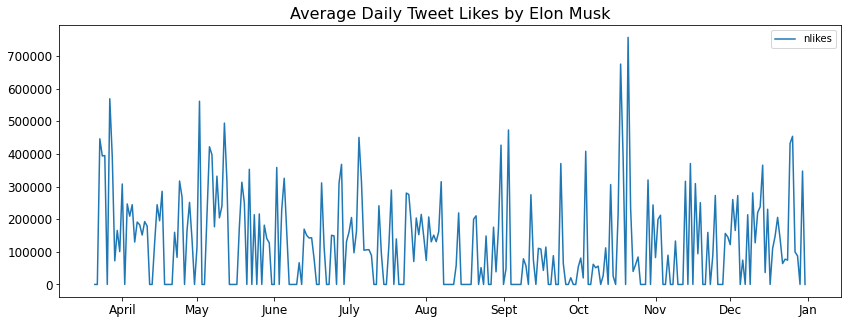

In [21]:
plt.figure(figsize=(14,5))

ax = sns.lineplot(data=my_api_tweet)  

ax.xaxis.set_major_locator(md.MonthLocator())
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%M-%D'))
ax.set_xticklabels(
    ['April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Jan'])

plt.xticks(size=12)
plt.yticks(size=12)

plt.title('Average Daily Tweet Likes by Elon Musk', size=16)

plt.show()

### Combine Kaggle Tweets and API Tweets

`nlike_tweet_df`: pandas data frame of average daily tweet likes from both data sources

In [22]:
nlike_tweet_df = pd.concat([my_tweet_df, my_api_tweet], axis = 0)

In [23]:
nlike_tweet_df.head(3)

,nlikes
2017-01-01,0.0
2017-01-02,0.0
2017-01-03,0.0


In [24]:
nlike_tweet_df.shape

(1826, 1)

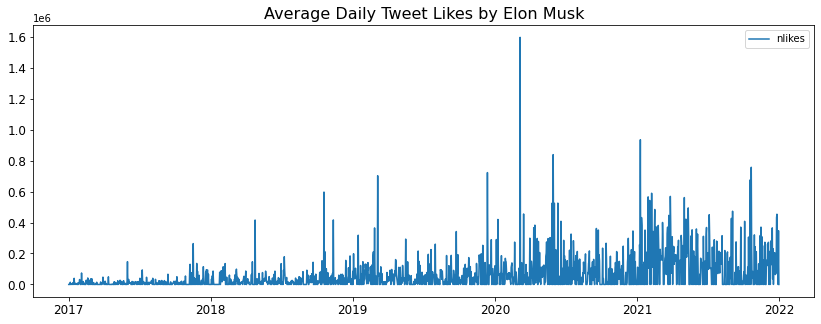

In [25]:
plt.figure(figsize=(14,5))

ax = sns.lineplot(data=nlike_tweet_df)  

ax.xaxis.set_major_locator(md.YearLocator(1,1,1))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%M-%D'))
ax.set_xticklabels(['2016', '2017', '2018', '2019', '2020', '2021', '2022'])

plt.xticks(size=12)
plt.yticks(size=12)

plt.title('Average Daily Tweet Likes by Elon Musk', size=16)

plt.show()

## Wikipedia Data

In [26]:
url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Elon_Musk/daily/2016010100/2022010100'

uh = urllib.request.urlopen(url)
data = uh.read()
js = json.loads(data.decode("utf-8"))

wiki_df = pd.json_normalize(js, record_path=['items'])

my_wiki_df = pd.DataFrame(wiki_df[['views']])

#removes trailing zeros on timestamp, and pandas format date index
my_wiki_df.index = pd.to_datetime(
    wiki_df['timestamp'].astype(str).str[:-2].astype(np.int64), format='%Y%m%d')

#extract same dates as twitter data
my_wiki_df = my_wiki_df['01-01-2017':'12-31-2021']

#rename column and index
my_wiki_df = my_wiki_df.rename(columns={'views':'wiki'})
my_wiki_df.index = my_wiki_df.index.rename('date')


In [27]:
my_wiki_df.head(3)

,wiki
date,
2017-01-01,19253
2017-01-02,26130
2017-01-03,24114


In [28]:
my_wiki_df.shape

(1826, 1)

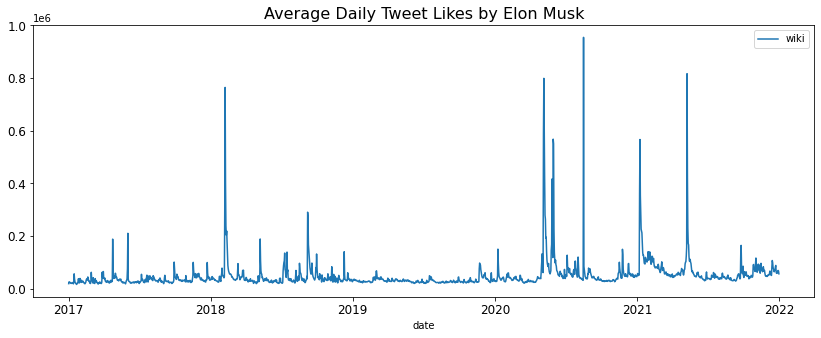

In [29]:
plt.figure(figsize=(14,5))

ax = sns.lineplot(data=my_wiki_df)  

ax.xaxis.set_major_locator(md.YearLocator(1,1,1))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%M-%D'))
ax.set_xticklabels(['2016', '2017', '2018', '2019', '2020', '2021', '2022'])

plt.xticks(size=12)
plt.yticks(size=12)

plt.title('Average Daily Tweet Likes by Elon Musk', size=16)

plt.show()

## Google Data

In [30]:
#build model
pytrend = TrendReq()

#provide your search terms
kw_list = ['Elon Musk']
pytrend.build_payload(kw_list=kw_list)

#historical interest
historicaldf = pytrend.get_historical_interest(kw_list, 
                                                year_start=2017, month_start=1, day_start=1, hour_start=0,
                                                year_end=2021, month_end=12, day_end=31, hour_end=0, 
                                                cat=0, geo='', gprop='', sleep=0)

HTTPSConnectionPool(host='trends.google.com', port=443): Read timed out. (read timeout=5)


In [31]:
#daily average popularity 
daily_series = historicaldf['Elon Musk'].resample('D').mean()

#Fill missing values with linear interpolation
daily_series = daily_series.fillna(daily_series.interpolate())

#pandas series --> pandas dataframe
my_google_df = pd.DataFrame(daily_series)

#rename column from 'Elon Musk' to 'google'
my_google_df = my_google_df.rename(columns={"Elon Musk": "google"})

In [32]:
my_google_df.head()

,google
date,
2017-01-01,49.208333
2017-01-02,51.250000
2017-01-03,50.833333
2017-01-04,53.583333
2017-01-05,52.625000


In [33]:
my_google_df.shape

(1826, 1)

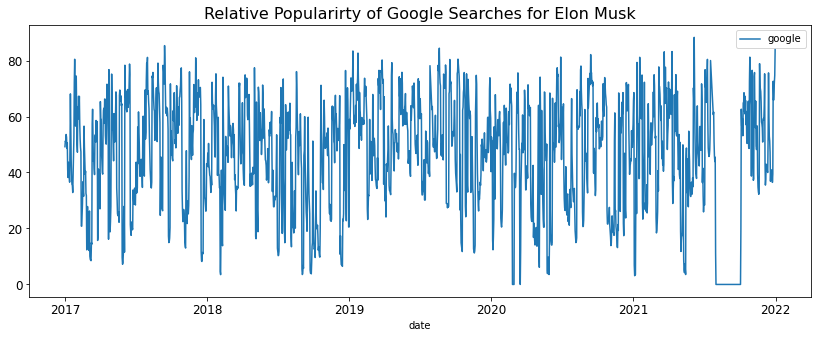

In [34]:
plt.figure(figsize=(14,5))

ax = sns.lineplot(data=my_google_df)  

ax.xaxis.set_major_locator(md.YearLocator(1,1,1))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%M-%D'))
ax.set_xticklabels(['2016', '2017', '2018', '2019', '2020', '2021', '2022'])

plt.xticks(size=12)
plt.yticks(size=12)

plt.title('Relative Popularirty of Google Searches for Elon Musk', size=16)

plt.show()

## S&P500 Index Data

In [35]:
start_date = datetime.datetime(2017, 1, 1)
end_date = datetime.datetime(2021, 12, 31)

my_sp_df = web.DataReader(['sp500'], 'fred', start_date, end_date)

#rename index 
my_sp_df.index = my_sp_df.index.rename('date')

#reindex for all dates in each year 
all_dates = pd.date_range(start='1/1/2017', end='12/31/2021')

#for days with no quotes, fill with missing value, (np.NaN is default)
my_sp_df = my_sp_df.reindex(all_dates)

#fill missing values with interpolate
#limit_direction = 'both' estimates both forward and backward projections
my_sp_df['sp500'] = my_sp_df['sp500'].fillna(my_sp_df['sp500'].interpolate(limit_direction='both'))

In [36]:
my_sp_df.head()

,sp500
2017-01-01,2257.83
2017-01-02,2257.83
2017-01-03,2257.83
2017-01-04,2270.75
2017-01-05,2269.00


In [37]:
my_sp_df.shape

(1826, 1)

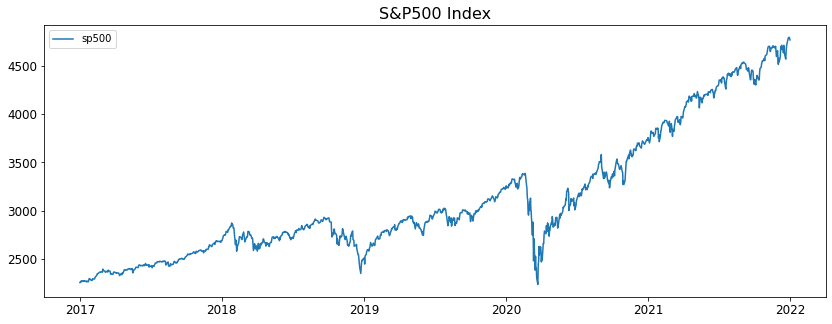

In [38]:
plt.figure(figsize=(14,5))

ax = sns.lineplot(data=my_sp_df)  

ax.xaxis.set_major_locator(md.YearLocator(1,1,1))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%M-%D'))
ax.set_xticklabels(['2016', '2017', '2018', '2019', '2020', '2021', '2022'])

plt.xticks(size=12)
plt.yticks(size=12)

plt.title('S&P500 Index', size=16)

plt.show()

## TSLA Data

In [39]:
finnhub_client = finnhub.Client(api_key="c7h1h52ad3ibsjtt5ug0")

In [40]:
epoch_start_date = 1483228800
epoch_end_date = 1640908800

In [41]:
#display the high, low, open, and closing prices of a security for a specific 
#period in epoch time (1/1/2017 - 12/31/2021)
tsla_candle_df = pd.DataFrame(finnhub_client.stock_candles(
    'TSLA', 'D', epoch_start_date, epoch_end_date))

#create time column and index in YYYY-MM-DD format
tsla_candle_df['date'] = pd.to_datetime(tsla_candle_df['t'],unit='s')
tsla_candle_df = tsla_candle_df.set_index('date')

# extract closing column ('c') with same index
my_tsla_df = pd.DataFrame(tsla_candle_df['c'], index=tsla_candle_df.index)
my_tsla_df = my_tsla_df.rename(columns={'c': 'tsla'})

In [42]:
#reindex for all dates in the year 
all_dates = pd.date_range(start='1/1/2017', end='12/31/2021')

#for days with no quotes, fill with missing value, (np.NaN is default)
my_tsla_df = my_tsla_df.reindex(all_dates)

#fill missing values with interpolate
#limit_direction = 'both' estimates both forward and backward projections
my_tsla_df['tsla'] = my_tsla_df['tsla'].fillna(my_tsla_df['tsla'].interpolate(limit_direction='both'))

In [43]:
my_tsla_df.head()

,tsla
2017-01-01,43.398
2017-01-02,43.398
2017-01-03,43.398
2017-01-04,45.398
2017-01-05,45.350


In [44]:
my_tsla_df.shape

(1826, 1)

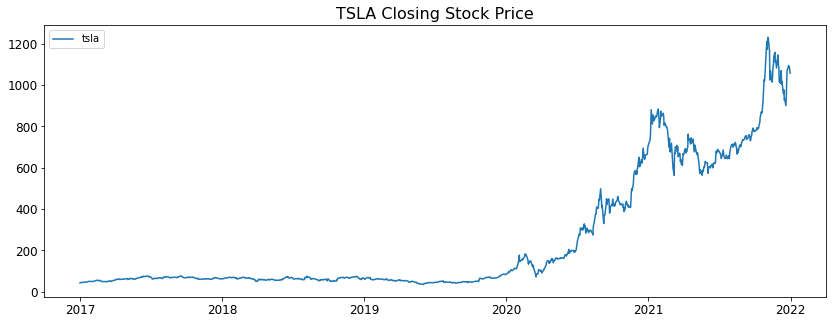

In [45]:
plt.figure(figsize=(14,5))

ax = sns.lineplot(data=my_tsla_df)  

ax.xaxis.set_major_locator(md.YearLocator(1,1,1))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%M-%D'))
ax.set_xticklabels(['2016', '2017', '2018', '2019', '2020', '2021', '2022'])

plt.xticks(size=12)
plt.yticks(size=12)

plt.title('TSLA Closing Stock Price', size=16)

plt.show()

## Combine data into one dataframe

In [434]:
elon_df = pd.concat(
    [my_tsla_df, nlike_tweet_df, my_wiki_df, my_google_df, my_sp_df], axis=1)

In [435]:
elon_df.head()

,tsla,nlikes,wiki,google,sp500
2017-01-01,43.398,0.0,19253,49.208333,2257.83
2017-01-02,43.398,0.0,26130,51.250000,2257.83
2017-01-03,43.398,0.0,24114,50.833333,2257.83
2017-01-04,45.398,0.0,24535,53.583333,2270.75
2017-01-05,45.350,14041.0,23229,52.625000,2269.00


# EDA

#### Target

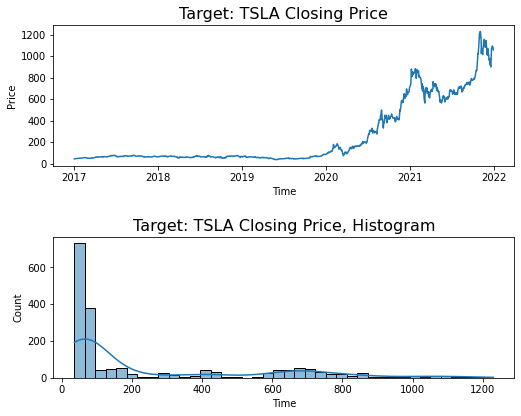

In [492]:
plt.figure(figsize = (8,7))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.2, 
                    hspace=0.5)

#plt.suptitle('Target Variable', size=18)

plt.subplot(2, 1, 1)
sns.lineplot(data=my_tsla_df, legend=False) 
plt.title("Target: TSLA Closing Price", size=16)
plt.xlabel('Time')
plt.ylabel('Price')


plt.subplot(2, 1, 2)
ax = sns.histplot(elon_df['tsla'], kde=True, bins=40) 
plt.title('Target: TSLA Closing Price, Histogram', size=16)
plt.xlabel('Time')

#plt.savefig('')
#files.download('') 

plt.show()

I'd like to work with a more stationary time series. Consider a series of the first difference, $X_t - X_{t-1}$

In [438]:
elon_df['tsla_diff'] = elon_df['tsla'].diff()

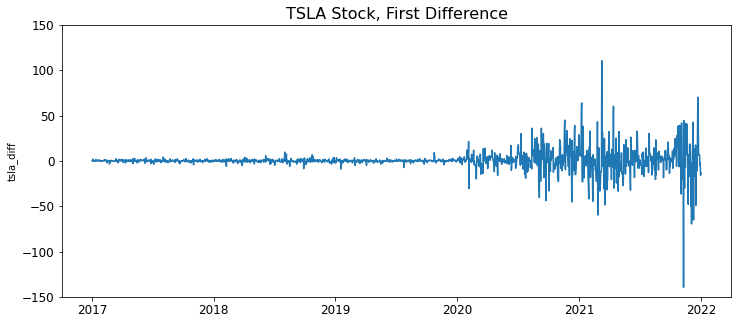

In [439]:
plt.figure(figsize=(12,5))

ax = sns.lineplot(data=elon_df['tsla_diff'], ci='sd', err_style='band')  

ax.xaxis.set_major_locator(md.YearLocator(1,1,1))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%M-%D'))
ax.set_xticklabels(['2016', '2017', '2018', '2019', '2020', '2021', '2022'])

plt.xticks(size=12)
plt.yticks(size=12)
plt.ylim([-150,150])

plt.title('TSLA Stock, First Difference', size=16)

plt.show()

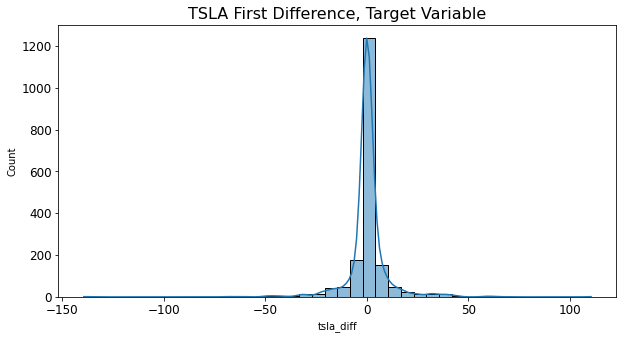

In [440]:
plt.figure(figsize=(10,5))

ax = sns.histplot(elon_df['tsla_diff'], kde=True, bins=40)  

#ax.xaxis.set_major_locator(md.YearLocator(1,1,1))
#ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%M-%D'))
#ax.set_xticklabels(['2016', '2017', '2018', '2019', '2020', '2021', '2022'])

plt.xticks(size=12)
plt.yticks(size=12)

plt.title('TSLA First Difference, Target Variable', size=16)

plt.show()

I will use consider using first difference, `tsla_diff`, as target variable

#### Features

In [441]:
#create difference variables for all features
elon_df['nlikes_diff'] = elon_df['nlikes'].diff()
elon_df['wiki_diff'] = elon_df['wiki'].diff()
elon_df['google_diff'] = elon_df['google'].diff()
elon_df['sp500_diff'] = elon_df['sp500'].diff()

In [442]:
#create seasonality variables
elon_df['year'] = elon_df.index.year
elon_df['weekofyear'] = elon_df.index.weekofyear

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  This is separate from the ipykernel package so we can avoid doing imports until


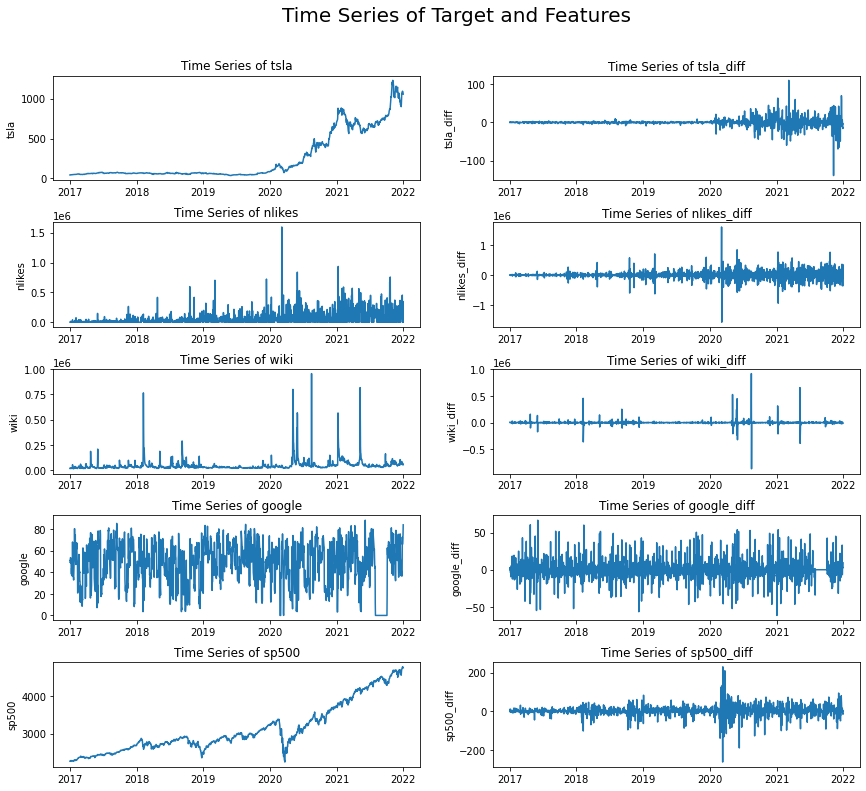

In [443]:
#Times Series Plots of Target and Features

series_columns = ['tsla', 'tsla_diff', 'nlikes', 'nlikes_diff', 'wiki', 
                  'wiki_diff', 'google', 'google_diff', 'sp500', 'sp500_diff']

plt.figure(figsize = (14,12))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

plt.suptitle('Time Series of Target and Features', size=20)

for i, col in enumerate(series_columns):
  plt.subplot(5, 2, i+1)
  sns.lineplot(data=elon_df, y=col, x=elon_df.index)
  plt.title("Time Series of {}".format(col))

#plt.savefig('')
#files.download('') 

plt.show()

Differencing seems to lead to stationary series for all features and target

### Pairplots 

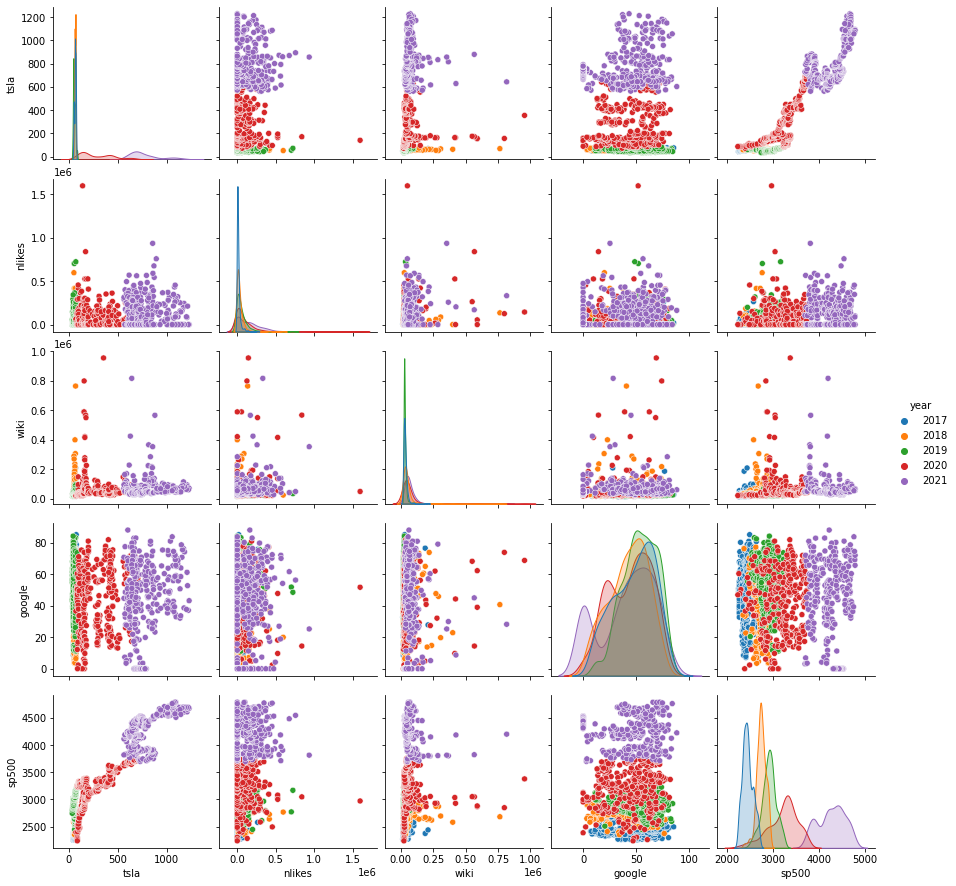

In [444]:
pairplot_df = elon_df.loc[:,['tsla', 'nlikes', 'wiki', 'google', 'sp500', 'year']]
sns.pairplot(data=pairplot_df, hue='year', palette="tab10")
plt.show()

There seems to be a clear yearly trend in most of the scatter plots 

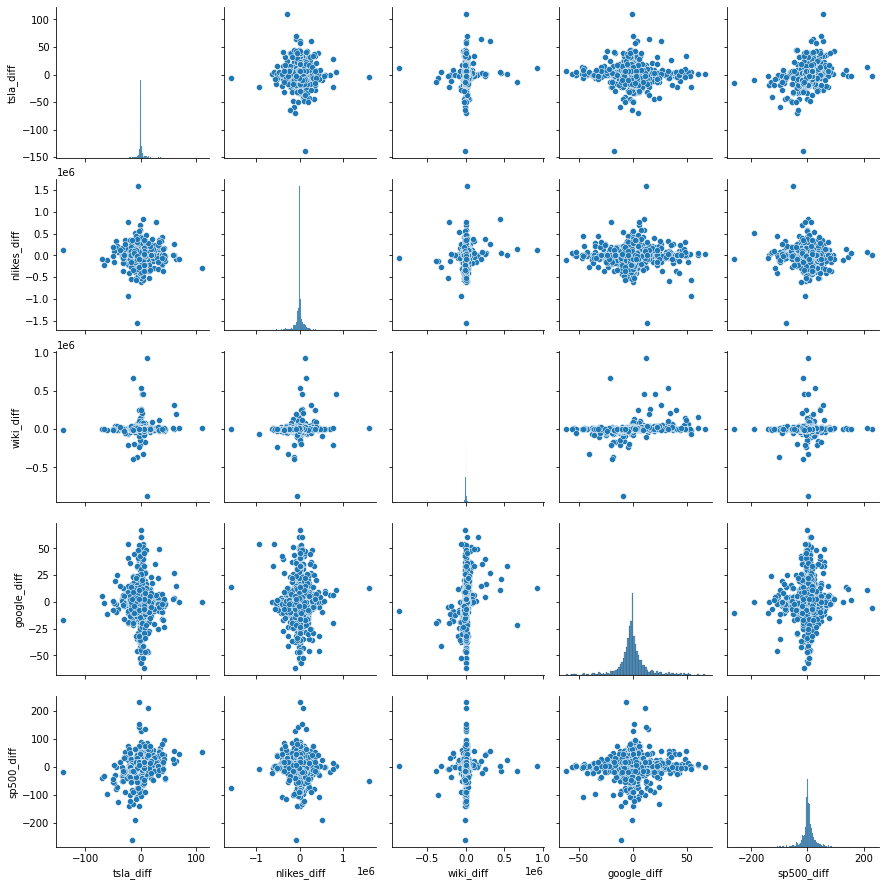

In [445]:
pairplot_diff_df = elon_df.loc[:,['tsla_diff', 'nlikes_diff', 'wiki_diff', 
                                  'google_diff', 'sp500_diff']]

sns.pairplot(data=pairplot_diff_df)
plt.show()

- Yearly trend not as prominent when comparing differenced series
- Less noticable trends when comparing differenced series compared to the original series
- Differenced series look approximently normal 

### Correlation

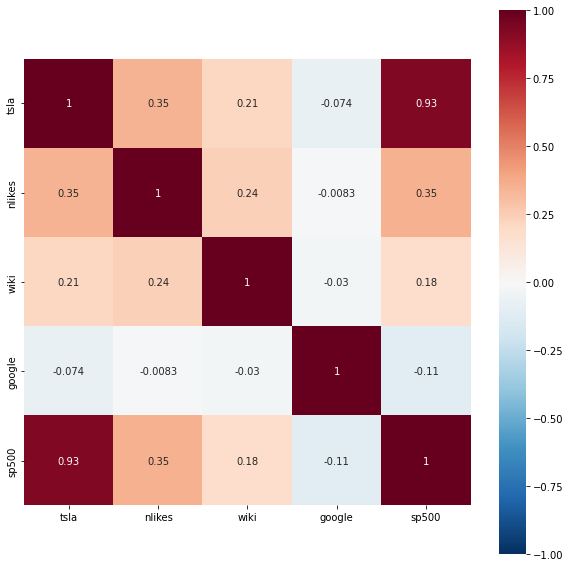

In [446]:
heat_map_df = elon_df.loc[:, ['tsla', 'nlikes', 'wiki', 'google', 'sp500']]

plt.figure(figsize=[10,10])

sns.heatmap(heat_map_df.corr(), square=True, vmin=-1, 
            vmax=1, center=0, cmap='RdBu_r', annot=True)

plt.show()

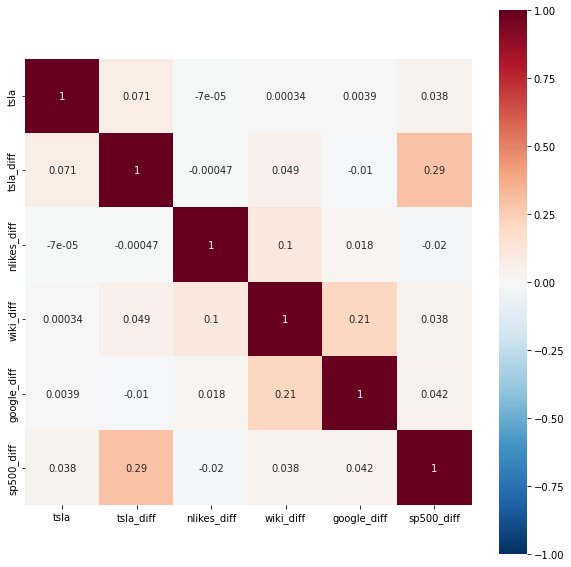

In [447]:
heatmap_diff_df = elon_df.loc[:,['tsla', 'tsla_diff', 'nlikes_diff', 
                                 'wiki_diff', 'google_diff', 'sp500_diff']]

plt.figure(figsize=[10,10])

sns.heatmap(heatmap_df.corr(), square=True, vmin=-1, 
            vmax=1, center=0, cmap='RdBu_r', annot=True)

plt.show()

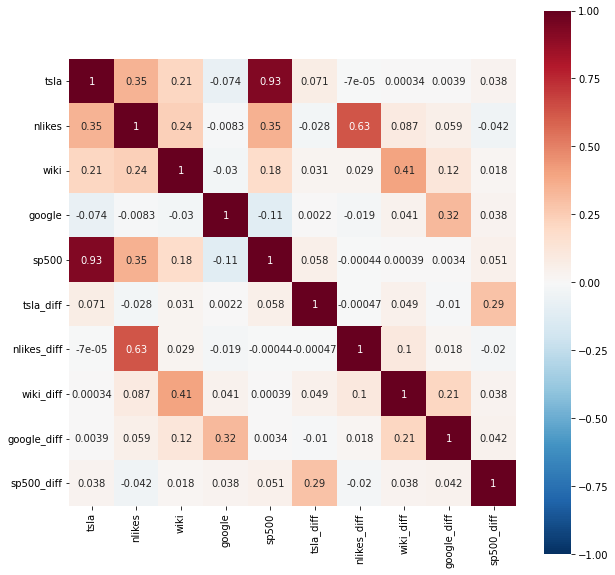

In [449]:
plt.figure(figsize=[10,10])

big_heatmap_df = elon_df.loc[:, ['tsla',	'nlikes',	'wiki',	'google',	
                'sp500', 'tsla_diff',	'nlikes_diff', 
                'wiki_diff', 'google_diff',	'sp500_diff']]

sns.heatmap(big_heatmap_df.corr(), square=True, vmin=-1, 
            vmax=1, center=0, cmap='RdBu_r', annot=True)

plt.show()

- Features are more correlated with `tsla` than `tsla_diff`, the first difference series of the tsla stock price

- May consider moving forward with using `tsla` instead of `tsla_diff`, despite lack of stationarity

### Rolling Window

3 day rolling average 

In [450]:
rolling3_df = pd.DataFrame(
    elon_df.loc[:,['tsla', 'nlikes', 'wiki', 'google', 'sp500']
                ].rolling(3).mean())
rolling3_df = rolling3_df.rename(
    columns={'tsla':'tsla_3', 'nlikes':'nlikes_3', 'wiki':'wiki_3', 
             'google':'google_3', 'sp500':'sp500_3'})

elon_df = pd.concat([elon_df, rolling3_df], axis=1)

7 day rolling average

In [451]:
rolling7_df = pd.DataFrame(
    elon_df.loc[:,['tsla', 'nlikes', 'wiki', 'google', 'sp500']
                ].rolling(7).mean())
rolling7_df = rolling7_df.rename(
    columns={'tsla':'tsla_7', 'nlikes':'nlikes_7', 'wiki':'wiki_7', 
             'google':'google_7', 'sp500':'sp500_7'})

elon_df = pd.concat([elon_df, rolling7_df], axis=1)

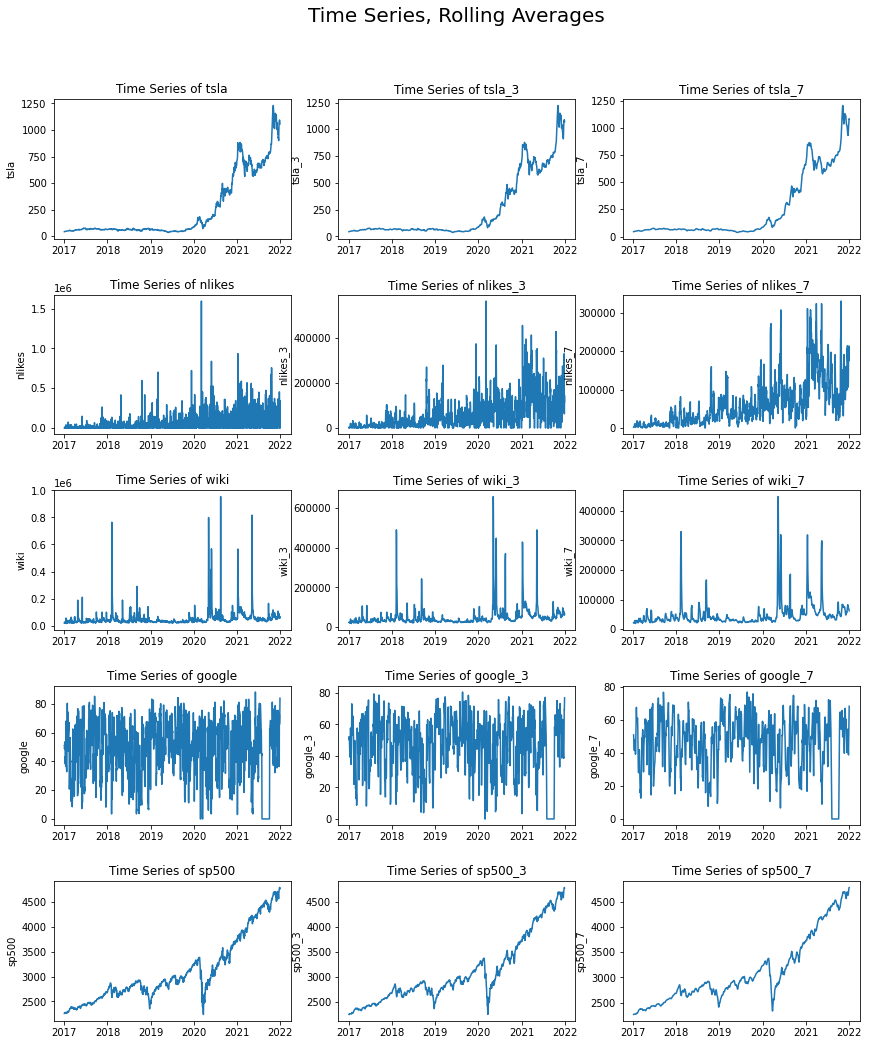

In [473]:
#Times Series Plots of Target and Features

plot_columns = ['tsla', 'tsla_3', 'tsla_7',
                'nlikes', 'nlikes_3', 'nlikes_7',
                'wiki', 'wiki_3', 'wiki_7',
                'google','google_3', 'google_7',
                'sp500', 'sp500_3', 'sp500_7'
                ]

plt.figure(figsize = (14,16))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

plt.suptitle('Time Series, Rolling Averages', size=20)

for i, col in enumerate(plot_columns):
  plt.subplot(5, 3, i+1)
  sns.lineplot(data=elon_df, y=col, x=elon_df.index)
  plt.title("Time Series of {}".format(col))

#plt.savefig('')
#files.download('') 

plt.show()

In [474]:
rolling_avg_df = elon_df.loc[:, ['tsla', 'tsla_3', 'tsla_7',
                'nlikes', 'nlikes_3', 'nlikes_7',
                'wiki', 'wiki_3', 'wiki_7',
                'google','google_3', 'google_7',
                'sp500', 'sp500_3', 'sp500_7']]

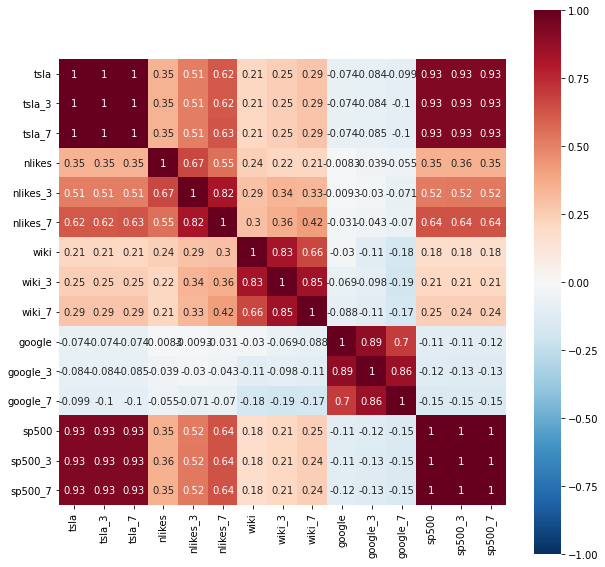

In [475]:
plt.figure(figsize=[10,10])

sns.heatmap(rolling_avg_df.corr(), square=True, vmin=-1, 
            vmax=1, center=0, cmap='RdBu_r', annot=True)

- Twitter Data, `nlikes`, more correlated with `tsla` as a rolling average (!) (but not `tsla_diff`)


- See heat plot below:

In [479]:
rolling_corr_df = elon_df.loc[:, ['tsla_diff', 
                                      'tsla', 'nlikes', 'nlikes_3', 
                                      'nlikes_7']]

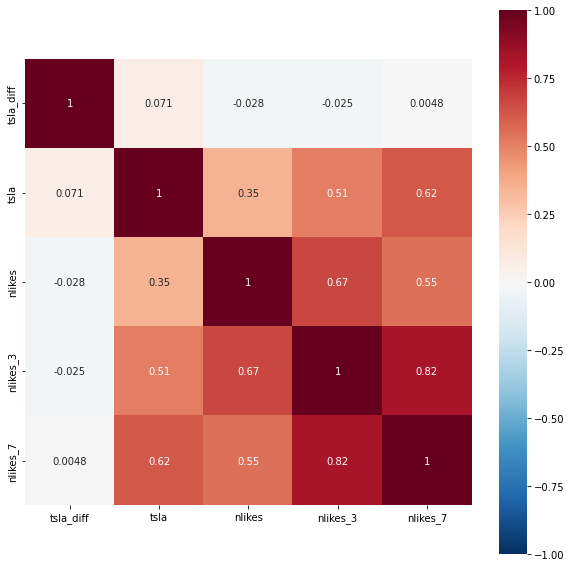

In [480]:
plt.figure(figsize=[10,10])

sns.heatmap(rolling_corr_df.corr(), square=True, vmin=-1, 
            vmax=1, center=0, cmap='RdBu_r', annot=True)

### Seasonality

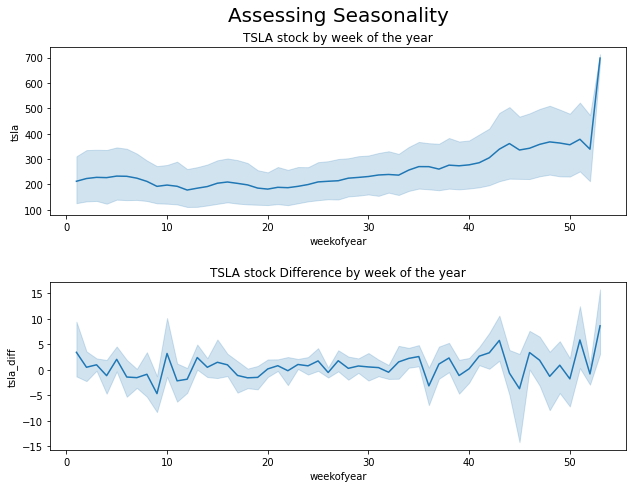

In [296]:
plt.figure(figsize = (10,7))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

plt.suptitle('Assessing Seasonality', size=20)

plt.subplot(2, 1, 1)
sns.lineplot(data=elon_df, x="weekofyear", y="tsla")
plt.title("TSLA stock by week of the year")

plt.subplot(2, 1, 2)
sns.lineplot(data=elon_df, x="weekofyear", y="tsla_diff")
plt.title("TSLA stock Difference by week of the year")

#plt.savefig('')
#files.download('') 

plt.show()

Little evidence of seasonality. Maybe slight seasonality for the last few months of the year. One possibility of the increase seen at week 53 is that the only years that contain the 53rd week are 2020 and 2021. On average, TSLA performed the best in the years 2020 and 2021. 

### Standardization

In [297]:
from sklearn.preprocessing import MinMaxScaler

In [349]:
cols_to_standardize = elon_df.loc[:,['tsla', 'nlikes', 'wiki', 'google', 
                                     'sp500', 'tsla_diff', 'nlikes_diff',
                                     'wiki_diff', 'google_diff', 'sp500_diff']]

In [351]:
scaler = MinMaxScaler()
elon_std_df = pd.DataFrame(
    scaler.fit_transform(cols_to_standardize), 
    columns=cols_to_standardize.columns)

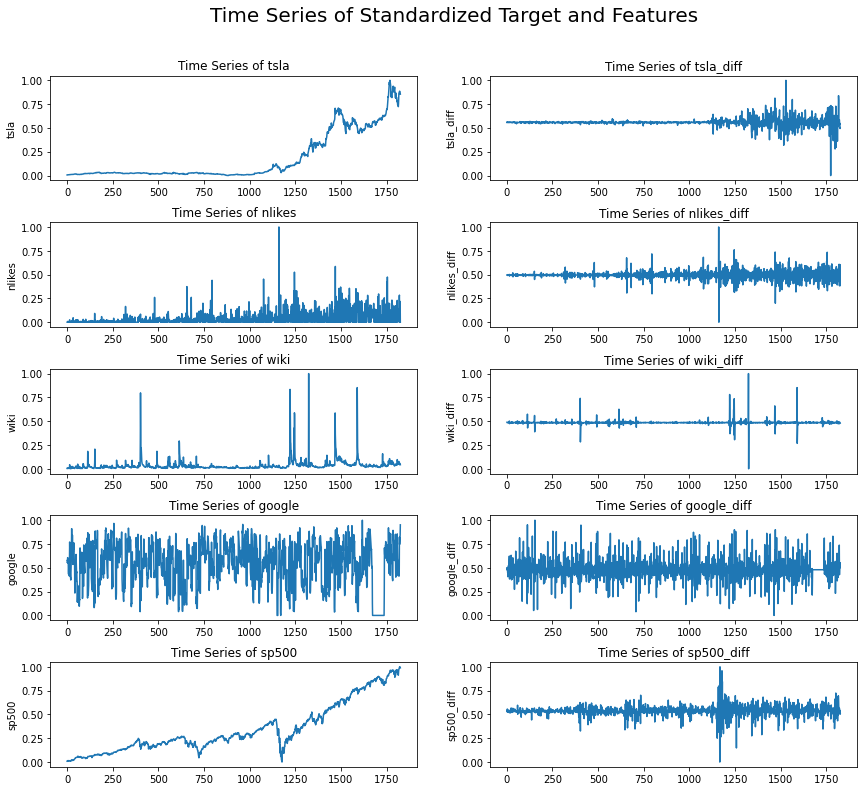

In [493]:
#Times Series Plots of Standardized Series

plt.figure(figsize = (14,12))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

plt.suptitle('Time Series of Standardized Target and Features', size=20)

for i, col in enumerate(series_columns):
  plt.subplot(5, 2, i+1)
  sns.lineplot(data=elon_std_df, y=col, x=elon_std_df.index)
  plt.title("Time Series of {}".format(col))

#plt.savefig('')
#files.download('') 

plt.show()